Sample Mean Porosity: 21.56%
95% CI: [20.51%, 22.60%]


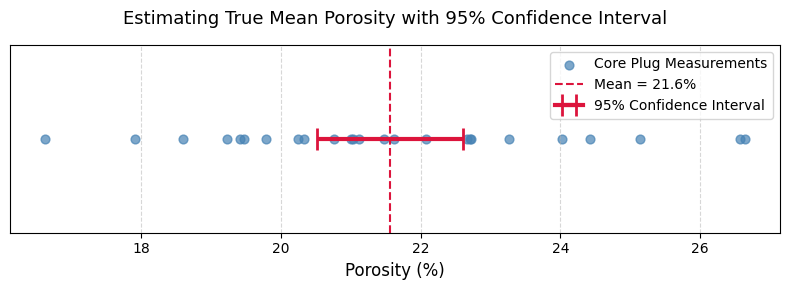

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Generate synthetic data ---
np.random.seed(202)
porosity = np.random.normal(loc=22, scale=3, size=25)  # %

# --- Calculate 95% CI ---
n = len(porosity)
mean = np.mean(porosity)
std_err = np.std(porosity, ddof=1) / np.sqrt(n)
t_crit = stats.t.ppf(0.975, df=n-1)  # 95% CI, two-tailed

ci_lower = mean - t_crit * std_err
ci_upper = mean + t_crit * std_err

print(f"Sample Mean Porosity: {mean:.2f}%")
print(f"95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]")

# --- Create publication-ready plot ---
plt.figure(figsize=(8, 3))
plt.scatter(porosity, np.zeros_like(porosity),
            color='steelblue', alpha=0.7, s=40, label='Core Plug Measurements')
plt.errorbar(mean, 0, xerr=[[mean - ci_lower], [ci_upper - mean]],
             color='crimson', linewidth=3, capsize=8, capthick=2,
             label='95% Confidence Interval')
plt.axvline(mean, color='crimson', linestyle='--', linewidth=1.5,
            label=f'Mean = {mean:.1f}%')

plt.yticks([])
plt.xlabel('Porosity (%)', fontsize=12)
plt.title('Estimating True Mean Porosity with 95% Confidence Interval',
          fontsize=13, pad=15)
plt.legend(loc='upper right')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('post_6_illustration.png', dpi=300, bbox_inches='tight')
plt.show()

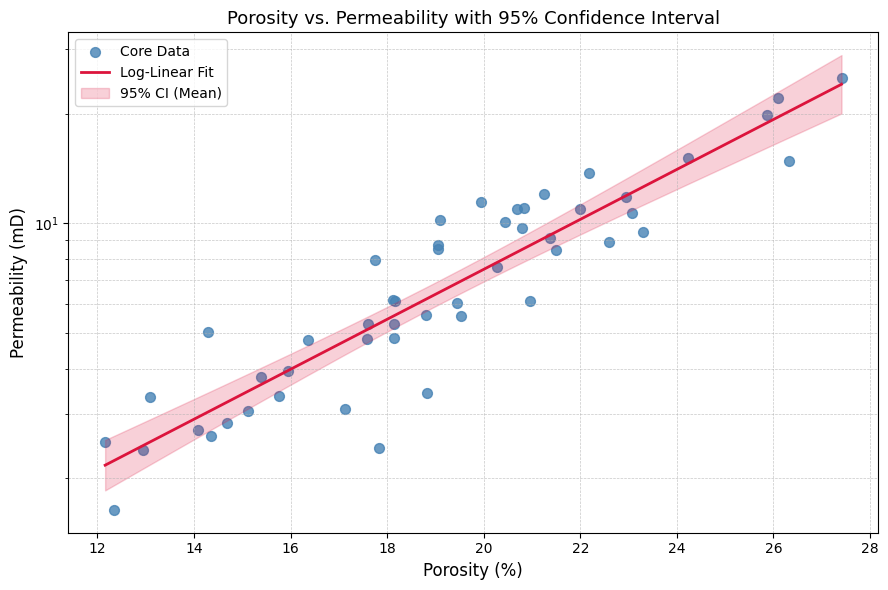

Model: ln(k) = 0.158 * φ + -1.142
R² = 0.836


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Generate Synthetic Data
# ----------------------------
np.random.seed(42)
n = 50

# Porosity (%) – realistic range
porosity = np.random.normal(loc=20, scale=4, size=n)
porosity = np.clip(porosity, 5, 32)  # Keep within physical bounds

# Permeability (mD) – log-normal, correlated with porosity
# True relationship: ln(k) = 0.15 * phi - 1.0 + noise
log_perm_true = 0.15 * porosity - 1.0
permeability = np.exp(log_perm_true + np.random.normal(scale=0.3, size=n))

# ----------------------------
# 2. Fit Log-Linear Model
# ----------------------------
log_perm = np.log(permeability)
phi = porosity

# Manual linear regression (to avoid SciPy)
phi_mean = np.mean(phi)
log_perm_mean = np.mean(log_perm)

# Slope and intercept
numerator = np.sum((phi - phi_mean) * (log_perm - log_perm_mean))
denominator = np.sum((phi - phi_mean)**2)
slope = numerator / denominator
intercept = log_perm_mean - slope * phi_mean

# Predicted log-perm
log_perm_pred = slope * phi + intercept

# ----------------------------
# 3. Compute 95% Confidence Interval for Mean Response
# ----------------------------
# Residuals and MSE
residuals = log_perm - log_perm_pred
mse = np.sum(residuals**2) / (n - 2)  # Mean squared error

# Standard error of the fit at each x
se_fit = np.sqrt(mse * (1/n + (phi - phi_mean)**2 / np.sum((phi - phi_mean)**2)))

# Critical t-value for 95% CI (df = n-2)
# Approximate t* ≈ 2.0 for n=50 (df=48); exact value:
from math import sqrt
import scipy  # Optional: if available, use scipy.stats.t.ppf(0.975, df=n-2)
# If SciPy is unavailable, use approximation:
t_star = 2.01  # t_{0.975, 48} ≈ 2.01

# Confidence interval in log space
ci_lower_log = log_perm_pred - t_star * se_fit
ci_upper_log = log_perm_pred + t_star * se_fit

# ----------------------------
# 4. Plot
# ----------------------------
# Sort for smooth curve
sorted_idx = np.argsort(phi)
phi_sorted = phi[sorted_idx]
perm_sorted = permeability[sorted_idx]
pred_sorted = np.exp(log_perm_pred[sorted_idx])
ci_low_sorted = np.exp(ci_lower_log[sorted_idx])
ci_up_sorted = np.exp(ci_upper_log[sorted_idx])

plt.figure(figsize=(9, 6))
plt.scatter(porosity, permeability, color='steelblue', alpha=0.8, s=50, label='Core Data')
plt.plot(phi_sorted, pred_sorted, color='crimson', linewidth=2, label='Log-Linear Fit')
plt.fill_between(phi_sorted, ci_low_sorted, ci_up_sorted, color='crimson', alpha=0.2, label='95% CI (Mean)')

plt.xlabel('Porosity (%)', fontsize=12)
plt.ylabel('Permeability (mD)', fontsize=12)
plt.title('Porosity vs. Permeability with 95% Confidence Interval', fontsize=13)
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('poro_perm_ci.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 5. Print Summary
# ----------------------------
r_squared = 1 - np.sum(residuals**2) / np.sum((log_perm - log_perm_mean)**2)
print(f"Model: ln(k) = {slope:.3f} * φ + {intercept:.3f}")
print(f"R² = {r_squared:.3f}")